# Lamb - MSDS 453 Project

## Index

### Kaggle Database Link

https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

### Other Articles to Consider

http://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf

https://www.proquest.com/docview/2798556468?pq-origsite=primo

https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
import collections
import re
import nltk
import string
import opendatasets as od
import pickle
from nltk.corpus import stopwords
from nltk import bigrams
from nltk.stem.porter import PorterStemmer
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics, svm
from sklearn.metrics import precision_score, recall_score, roc_curve, confusion_matrix, jaccard_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from keras.layers import SimpleRNN, LSTM, Dense, Dropout, Activation, Flatten
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, AdaBoostClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

### Pickle Load

In [2]:
# Load pickled variables
# with open('session.pkl', 'rb') as f:
#     data = pickle.load(f)

In [3]:
# #pickeling file to allow for loading calculation directionly into memory without recomputing
# ##as this is a computationally intensive wb this allows for incremental progress to be made without recommputing the whole file
# with open('session.pkl', 'wb') as f:
#     pickle.dump({
#             'cnt' : cnt,
#             'ltt' : ltt,
#             'lrt' : lrt,
#             'gnt' : gnt,
#             'bnt' : bnt,
#             'mbt' : mbt,
#             'srt' : srt,
#             'spt' : spt,
#             'slt' : slt,
#             'rft' : rft,
#             'gbt' : gbt,
#             'ett' : ett,
#             'adt' : adt,
#             'xgt' : xgt,
#             'xrt' : xrt,
#             'cnr' : cnr,
#             'ltr' : ltr,
#             'lrr' : lrr,
#             'gnr' : gnr,
#             'bnr' : bnr,
#             'mbr' : mbr,
#             'srr' : srr,
#             'spr' : spr,
#             'slr' : slr,
#             'rfr' : rfr,
#             'gbr' : gbr,
#             'etr' : etr,
#             'adr' : adr,
#             'xgr' : xgr,
#             'xrr' : xrr
#                 }, f)

### Importing Data

In [4]:
#loading corpus into data frame
df = pd.read_csv("spam.csv", encoding = "ISO-8859-1", engine = "python")
print(df.shape)

(5572, 5)


In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Cleaning Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
#looking at the data in the unnamed columns
df[df['Unnamed: 2'].isnull() == False].head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN


In [8]:
df[df['Unnamed: 3'].isnull() == False].head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
2170,ham,\CAN I PLEASE COME UP NOW IMIN TOWN.DONTMATTER...,JUST REALLYNEED 2DOCD.PLEASE DONTPLEASE DONTIG...,"U NO THECD ISV.IMPORTANT TOME 4 2MORO\""""",NaN


In [9]:
df[df['Unnamed: 4'].isnull() == False].head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
2255,ham,I just lov this line: \Hurt me with the truth,I don't mind,i wil tolerat.bcs ur my someone..... But,"Never comfort me with a lie\"" gud ni8 and swe..."
3525,ham,\HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DE...,HAD A COOL NYTHO,TX 4 FONIN HON,"CALL 2MWEN IM BK FRMCLOUD 9! J X\"""""
4668,ham,"When I was born, GOD said, \Oh No! Another IDI...",GOD said,"\""OH No! COMPETITION\"". Who knew","one day these two will become FREINDS FOREVER!"""


In [10]:
#the unknown columns are sparsely populated and most that are are populated appear to contain irrelevant information 
#(such as time or address info).  droping these columns
to_drop = ['Unnamed: 2',"Unnamed: 3","Unnamed: 4"]
df = df.drop(columns = to_drop)
print(df.shape)

(5572, 2)


In [11]:
#renamining columns
rename_list = {'v1':'label','v2':'documents'}
df = df.rename(columns=rename_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5572 non-null   object
 1   documents  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [12]:
#neither column has any null values, but lets check to make sure there is non-blank text in the documents
df_temp = df['documents'].str.len() - df['documents'].str.count(' ')
sum(df_temp == 0)

0

In [13]:
#okay so all the documents contain at least some characters.  Lets check that our label is a binary indicator as expected
label_list = df.label.unique()
print(label_list)

['ham' 'spam']


In [14]:
#creating one hotkey on label
label_binary = pd.get_dummies(df.label)
label_binary= label_binary.drop(columns='ham')
label_binary = label_binary.rename(columns={'spam':'label_binary'})
df = pd.concat([df,label_binary],axis=1)

In [15]:
#checking hotkey join and binary hotkey labeling
print(df.shape)
print(df[df['label']=='ham'].label_binary.unique())
print(df[df['label']=='spam'].label_binary.unique())

(5572, 3)
[0]
[1]


In [16]:
#checking for duplicates
df.duplicated().sum()

403

In [17]:
#dropping duplicated
df = df.drop_duplicates()
df.shape

(5169, 3)

### EDA

In [18]:
#looking at the frequency of ham versus spam
label_count = df.groupby('label').count()
print(label_count)

       documents  label_binary
label                         
ham         4516          4516
spam         653           653


In [19]:
#lets look at how wordy our documents are - first creating a word count
documents = df['documents'].tolist()
word_count = [] 
for i in documents:
    word_count.append(len(i.split()))
print(len(word_count))

5169


In [20]:
#calculating mean, standard deviations, min, and max
min_val = min(word_count)
max_val =max(word_count)
mean_val = np.mean(word_count)
var_val = np.std(word_count)
stat_label = pd.Series(('min','max','mean','std'))
stats = pd.Series((min_val,max_val,mean_val,var_val))
d = {'label':stat_label,'value':stats}
df_stat = pd.DataFrame(data=d)
df_stat

,label,value
0,min,1.000000
1,max,171.000000
2,mean,15.340685
3,std,11.067417


In [21]:
#adding the word count into the data frame
df['word_count'] = np.array(word_count)
df.shape

(5169, 4)

In [22]:
#looking at a few of these one word documents
df[df['word_count'] == 1].head()

,label,documents,label_binary,word_count
260,ham,Yup,0,1
275,ham,Thanx...,0,1
283,ham,Okie...,0,1
286,ham,Ok..,0,1
782,ham,Beerage?,0,1


In [23]:
#what percentage of the documents have only 1 word
sum(df['word_count'] == 1)/len(df)

0.003869220352099052

In [24]:
range(len(documents))

range(0, 5169)

In [25]:
#look at the most common words - first prep a word list
word_list = []
for i in range(len(documents)):
    word_list.append(documents[i].lower().split())
master_word_list = list(itertools.chain(*word_list))

In [26]:
#now count the words
count_words = collections.Counter(master_word_list)
count_words.most_common(20)

[('i', 2095),
 ('to', 2055),
 ('you', 1832),
 ('a', 1281),
 ('the', 1223),
 ('and', 919),
 ('u', 890),
 ('in', 785),
 ('is', 766),
 ('my', 676),
 ('for', 653),
 ('your', 618),
 ('me', 579),
 ('of', 552),
 ('have', 532),
 ('on', 476),
 ('call', 468),
 ('are', 457),
 ('that', 453),
 ('it', 440)]

### Text Preprocessing

In [27]:
#making text lowercase
df['documents_clean'] = df['documents'].str.lower()

In [28]:
#replacing URLs with keyword "URL"
df['documents_clean'] = df['documents_clean'].str.replace(r'https?://\S+|www\.\S+', 'url')

C:\Users\CGLam\AppData\Local\Temp\ipykernel_3740\3020070343.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['documents_clean'] = df['documents_clean'].str.replace(r'https?://\S+|www\.\S+', 'url')


In [29]:
#loading stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(len(stop_words))

179


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CGLam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
#removing stop words
df['documents_clean'] = df['documents_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [31]:
#remove punctuation
df['documents_clean'] = df['documents_clean'].str.replace(r'[^\w\s]+', '')

C:\Users\CGLam\AppData\Local\Temp\ipykernel_3740\2423228234.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['documents_clean'] = df['documents_clean'].str.replace(r'[^\w\s]+', '')


In [32]:
#re-reviewing most common words to see if it makes sense to create any custom stop words
word_list_2 = []
documents_2 = df['documents_clean'].tolist()
for i in range(len(documents_2)):
    word_list_2.append(documents_2[i].lower().split())
master_word_list_2 = list(itertools.chain(*word_list_2))
count_words_2 = collections.Counter(master_word_list_2)
count_words_2.most_common(20)

[('u', 1001),
 ('call', 487),
 ('im', 447),
 ('2', 443),
 ('get', 364),
 ('ur', 316),
 ('go', 269),
 ('4', 257),
 ('ltgt', 254),
 ('ok', 251),
 ('free', 243),
 ('know', 239),
 ('got', 231),
 ('like', 231),
 ('good', 217),
 ('come', 210),
 ('ill', 206),
 ('you', 200),
 ('time', 199),
 ('now', 198)]

In [33]:
#creating custom stop words
custom_stopwords = {'u','im','ur','ill','you'}

In [34]:
#remove custom stop words
df['documents_clean'] = df['documents_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom_stopwords)]))

In [35]:
#remove non-character tokens
df['documents_clean'] = df['documents_clean'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

In [36]:
#applying stemming
stemmer = PorterStemmer()
df['documents_clean'] = df['documents_clean'].apply(lambda x: ' '.join([stemmer.stem(y) for y in x.split()]))

In [37]:
df.head()

,label,documents,label_binary,word_count,documents_clean
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,0,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,free entri wkli comp win fa cup final tkt may ...
3,ham,U dun say so early hor... U c already then say...,0,11,dun say earli hor c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,nah think goe usf live around though


In [38]:
#export preprocessed data to excel for further review 
#df.to_excel('preprocessed.xlsx')

### Tokenize the Data

In [39]:
def define_tokenizer(x):
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer
    
def encode(x2, tokenizer):
    encoded_sentences = tokenizer.texts_to_sequences(x2)
    encoded_sentences = tf.keras.preprocessing.sequence.pad_sequences(encoded_sentences, padding='post')
    return encoded_sentences

In [40]:
tokenizer = define_tokenizer(df['documents_clean'])
s_strings = encode(df['documents_clean'],tokenizer)

In [41]:
#checking that we have appropriate number of documents
len(s_strings)

5169

In [42]:
#quick look at encoding...text of first clean document
df['documents_clean'][0]

'go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

In [43]:
#encoding of that document
s_strings[0]

array([   2, 2952,  271,  540,  568,  954,   43,   66,  325,  955,   88,
       2089,  956,   11, 2953,   64,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0])

In [44]:
#pulling these words out of the dictionary to make sure we encoded as expected
d = tokenizer.word_index
print(d['go'])
print(d['jurong'])
print(d['point'])
print(d['crazi'])
print(d['avail'])
print(d['bugi'])
print(d['n'])
print(d['great'])
print(d['world'])
print(d['la'])
print(d['e'])
print(d['buffet'])
print(d['cine'])
print(d['got'])
print(d['amor'])
print(d['wat'])

2
2952
271
540
568
954
43
66
325
955
88
2089
956
11
2953
64


### Keras Cross Validation Design

In [45]:
#converting tokenized data to pandas dataframe
#we will eventually convert back to array but the pd will make the cross validation setup easier
s_pandas = pd.DataFrame(data=s_strings)
s_pandas['label'] = df['label_binary'].tolist()
s_pandas['doc'] = df['documents_clean'].tolist()
print(s_pandas.shape)
print(s_pandas.head())

(5169, 81)
     0     1    2     3     4     5     6    7     8    9  ...  71  72  73  \
0    2  2952  271   540   568   954    43   66   325  955  ...   0   0   0   
1    6   226  569   326  1413     0     0    0     0    0  ...   0   0   0   
2    9   413  796   797   129  2090  1087  304  2091  206  ...   0   0   0   
3  146    40  263  2092    97    73    40    0     0    0  ...   0   0   0   
4  750    22  338   696   176   128   339    0     0    0  ...   0   0   0   

   74  75  76  77  78  label  \
0   0   0   0   0   0      0   
1   0   0   0   0   0      0   
2   0   0   0   0   0      1   
3   0   0   0   0   0      0   
4   0   0   0   0   0      0   

                                                 doc  
0  go jurong point crazi avail bugi n great world...  
1                                ok lar joke wif oni  
2  free entri wkli comp win fa cup final tkt may ...  
3                    dun say earli hor c alreadi say  
4               nah think goe usf live around though

In [46]:
#creating the cross validation datasets
y = s_pandas['label'].to_numpy()
y = y.reshape(-1,1)
x = s_pandas.drop(columns=['label'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=9)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2584, 80)
(2585, 80)
(2584, 1)
(2585, 1)


In [47]:
#checking that i split this correctly
print(x_train.head())
print(y_train[:4])

         0     1    2     3    4    5    6     7    8    9  ...  70  71  72  \
2194  4640    14   91    48    0    0    0     0    0    0  ...   0   0   0   
2259  4678   253   27  1122    0    0    0     0    0    0  ...   0   0   0   
3644    65   487   20    58  986  394   36   798   14  107  ...   0   0   0   
107      7  3025  433   199  416    8  204  1108  161   20  ...   0   0   0   
2584   208    73  300  1270   43  500  202     0    0    0  ...   0   0   0   

      73  74  75  76  77  78  \
2194   0   0   0   0   0   0   
2259   0   0   0   0   0   0   
3644   0   0   0   0   0   0   
107    0   0   0   0   0   0   
2584   0   0   0   0   0   0   

                                                    doc  
2194                                velli good ye pleas  
2259                             nohe join today itself  
3644      happi sad one thing past is it more good morn  
107   know grumpi old peopl mom like better lie alwa...  
2584                  yup alreadi thanx pr

In [48]:
#splitting out the text doc from the encoded data
train_doc = x_train['doc']
test_doc = x_test['doc']
x_train = x_train.drop(columns=['doc'])
x_test = x_test.drop(columns=['doc'])
print(train_doc.shape)
print(test_doc.shape)
print(x_train.shape)
print(x_test.shape)

(2584,)
(2585,)
(2584, 79)
(2585, 79)


In [49]:
#our data needs to be in array format so we conver the new dataframes back to arrays
x_train_array = x_train.to_numpy()
x_test_array = x_test.to_numpy()
#and checking shaping
print(len(x_train_array))
print(len(x_test_array))

2584
2585


In [50]:
print(x_train_array.shape)
print(x_test_array.shape)
print(y_train.shape)
print(y_test.shape)

(2584, 79)
(2585, 79)
(2584, 1)
(2585, 1)


In [51]:
#saving index of records that made it into test versus train
train_index = x_train.index
test_index = x_test.index

### One Hotkey Encoding (Count Vectorization)

In [52]:
#creating the one hotkey on clean documents
vec = CountVectorizer()
X_train_count = vec.fit_transform(df['documents_clean'].values)
X_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [53]:
#checking shape
len(X_train_count.toarray())

5169

In [54]:
#moving into pandas dataframe
df_one = pd.DataFrame(X_train_count.toarray())
len(df_one)

5169

In [55]:
#using index to split into train and test
df_train = df_one.iloc[train_index]
df_test = df_one.iloc[test_index]
print(df_train.shape)
print(df_test.shape)

(2584, 6793)
(2585, 6793)


### One Hotkey Encoding (TFID Vectorization)

In [56]:
#creating the one hotkey on clean documents
# vec2 = TfidfVectorizer(max_features=7000)
# X_train_tfidf = vec2.fit_transform(df['documents_clean'].values)
# X_train_tfidf.toarray()

In [57]:
#checking shape
# len(X_train_tfidf.toarray())

In [58]:
#moving into pandas dataframe
# df_vec = pd.DataFrame(X_train_tfidf.toarray())
# df_vec.shape

In [59]:
#using index to split into train and test
# df_train = df_vec.iloc[train_index]
# df_test = df_vec.iloc[test_index]
# print(df_train.shape)
# print(df_test.shape)

### Defining Metrics Function

In [60]:
def class_metrics(method):
    a = print("Accuracy:",metrics.accuracy_score(y_test, method))
    p = print("Precision:",metrics.precision_score(y_test, method))
    r =print("Recall:",metrics.recall_score(y_test, method))
    return a, p, r;

In [61]:
def class_accuracy(method):
    a = metrics.accuracy_score(y_test, method)
    return a

In [62]:
def class_precision(method):
    p = metrics.precision_score(y_test, method)
    return p;

In [63]:
def class_recall(method):
    r =metrics.recall_score(y_test, method)
    return r;

In [64]:
def class_f1(method):
    r =metrics.f1_score(y_test, method)
    return r;

In [65]:
def predict_metrics(method):
    a = print("Accuracy:",metrics.accuracy_score(y_train, method))
    p = print("Precision:",metrics.precision_score(y_train, method))
    r =print("Recall:",metrics.recall_score(y_train, method))
    return a, p, r;

### Setting Up Tensors for each of the Datasets

In [66]:
#creating the tensor
# ts_train = tf.data.Dataset.from_tensor_slices((x_train_array, y_train))
# ts_holdout = tf.data.Dataset.from_tensor_slices((x_test_array, y_test))

In [67]:
#padding
#ts_train = ts_train.padded_batch(32, padded_shapes=([-1], []))
#ts_holdout = ts_holdout.padded_batch(32, padded_shapes=([-1], []))

### Establishing Early Stopping Criteria for NN training

In [68]:
callback = keras.callbacks.EarlyStopping(monitor='precision',patience=15,min_delta=.001,verbose=1,mode="max")

### Under Sampling Pipeline

In [69]:
under = RandomUnderSampler(sampling_strategy=0.5)

### Logistic Regression

In [70]:
lr = LogisticRegression(solver="lbfgs",random_state=9,warm_start=False,class_weight='balanced')
lrm = lr.fit(df_train, y_train.ravel())
lrr = lrm.predict(df_train)
lrt = lrm.predict(df_test)

In [71]:
class_metrics(lrt)

Accuracy: 0.9725338491295938
Precision: 0.9180887372013652
Recall: 0.8512658227848101


(None, None, None)

In [72]:
print(lrm.get_params())

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 9, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


### Problems with Naive Bayes

http://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf

Problems with Naive Bayes:
    Doesnt handle imbalanced data well
    Assumes feature indepedence

### Gaussian Naive Bayes Model

In [73]:
gn = GaussianNB()
gn_steps = [('under', under), ('model', gn)]
gn_pipeline = Pipeline(steps=gn_steps)
gnm = gn_pipeline.fit(df_train, y_train)
gnr = gnm.predict(df_train)
gnt = gnm.predict(df_test)

In [74]:
class_metrics(gnt)

Accuracy: 0.8096711798839459
Precision: 0.3820375335120643
Recall: 0.9018987341772152


(None, None, None)

In [75]:
print(gnm.get_params())

{'memory': None, 'steps': [('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', GaussianNB())], 'verbose': False, 'under': RandomUnderSampler(sampling_strategy=0.5), 'model': GaussianNB(), 'under__random_state': None, 'under__replacement': False, 'under__sampling_strategy': 0.5, 'model__priors': None, 'model__var_smoothing': 1e-09}


### Bernouli Naive Bayes Model 

In [76]:
bn = BernoulliNB()
bn_steps = [('under', under), ('model', bn)]
bn_pipeline = Pipeline(steps=bn_steps)
bnm = bn_pipeline.fit(df_train, y_train)
bnr = bnm.predict(df_train)
bnt = bnm.predict(df_test)

In [77]:
class_metrics(bnt)

Accuracy: 0.9617021276595744
Precision: 0.9909502262443439
Recall: 0.6930379746835443


(None, None, None)

In [78]:
print(bn.get_params())

{'alpha': 1.0, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}


### MultiNomimail Bayes Model

In [79]:
mb = MultinomialNB()
mb_steps = [('under', under), ('model', mb)]
mb_pipeline = Pipeline(steps=mb_steps)
mbm = mb_pipeline.fit(df_train, y_train)
mbr = mbm.predict(df_train)
mbt = mbm.predict(df_test)

In [80]:
class_metrics(mbt)

Accuracy: 0.9504835589941973
Precision: 0.7373737373737373
Recall: 0.9240506329113924


(None, None, None)

In [81]:
print(mb.get_params())

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}


### Hypertuned SVM

In [82]:
# param_grid_sv = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid','linear']}
# grid_sv = GridSearchCV(svm.SVC(random_state=9,class_weight='balanced'),param_grid_sv,refit=True,verbose=3,scoring='precision',cv=5)
# shm = grid_sv.fit(df_train,y_train.ravel())
# print(grid_sv.best_estimator_)

In [83]:
# svr = grid_sv.predict(df_train)
# svt = grid_sv.predict(df_test)

In [84]:
# class_metrics(svt)

In [85]:
# df_sv_grid = pd.DataFrame(data=grid_sv.cv_results_)

In [86]:
# df_sv_grid.to_excel("SVC_GridSearch.xlsx")

###  Best Fit SVM (precision)

In [87]:
sb = svm.SVC(kernel='poly',random_state=9,C=.1,gamma=1,class_weight='balanced')
sbm = sb.fit(df_train, y_train.ravel())
sbr = sbm.predict(df_train)
sbt = sbm.predict(df_test)

In [88]:
class_metrics(sbt)

Accuracy: 0.9326885880077369
Precision: 0.94375
Recall: 0.4778481012658228


(None, None, None)

In [89]:
print(sbm.get_params())

{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1, 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': 9, 'shrinking': True, 'tol': 0.001, 'verbose': False}


### Best Fit SVM (f1)

In [90]:
sb2 = svm.SVC(kernel='rbf',random_state=9,C=10,gamma=0.1,class_weight='balanced')
sbm2 = sb2.fit(df_train, y_train.ravel())
sbr2 = sbm2.predict(df_train)
sbt2 = sbm2.predict(df_test)

In [91]:
class_metrics(sbt2)

Accuracy: 0.9663442940038685
Precision: 0.9872340425531915
Recall: 0.7341772151898734


(None, None, None)

In [92]:
print(sbm2.get_params())

{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 9, 'shrinking': True, 'tol': 0.001, 'verbose': False}


### Hyertuned Random Forest Classifier

In [93]:
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 1000, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {
#                'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap
#                 }
# print(random_grid)

In [94]:
# rf = RandomForestClassifier(class_weight="balanced",random_state=9)
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=9, scoring='precision')
# rf_random.fit(df_train, y_train.ravel())

In [95]:
# class_metrics(rf_random)

In [96]:
# rhr = rf_random.predict(df_train)
# rgt = rf_random.predict(df_test)

In [97]:
# df_rf_grid = pd.DataFrame(data=rf_random.cv_results_)

In [98]:
# df_rf_grid.to_excel("RF_GridSearch.xlsx")

### Best Fit RF (precision)

In [99]:
rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=9,
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=307,
    bootstrap=True)
rfm = rf.fit(df_train, y_train.ravel())
rfr = rfm.predict(df_train)
rft = rfm.predict(df_test)

In [100]:
class_metrics(rft)

Accuracy: 0.9647969052224371
Precision: 0.9955947136563876
Recall: 0.7151898734177216


(None, None, None)

In [101]:
#looking at default parameters
print(rf.get_params())
print('Max Depth of any Tree: ',max([estimator.tree_.max_depth for estimator in rf.estimators_]))

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 307, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 9, 'verbose': 0, 'warm_start': False}
Max Depth of any Tree:  307


### Best Fit RF (f1)

In [102]:
rf2 = RandomForestClassifier(
    class_weight="balanced",
    random_state=9,
    n_estimators=1577,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features='auto',
    max_depth=307,
    bootstrap=False)
rfm2 = rf2.fit(df_train, y_train.ravel())
rfr2 = rfm2.predict(df_train)
rft2 = rfm2.predict(df_test)

C:\Users\CGLam\anaconda3_\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [103]:
class_metrics(rft2)

Accuracy: 0.9822050290135397
Precision: 0.972027972027972
Recall: 0.879746835443038


(None, None, None)

In [104]:
#looking at default parameters
print(rf2.get_params())
print('Max Depth of any Tree: ',max([estimator.tree_.max_depth for estimator in rf2.estimators_]))

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 307, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1577, 'n_jobs': None, 'oob_score': False, 'random_state': 9, 'verbose': 0, 'warm_start': False}
Max Depth of any Tree:  307


### Hyertuned Gradient Boosted Trees

In [105]:
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 3)]
# max_features = ['log2', 'sqrt']
# max_depth = [int(x) for x in np.linspace(1, 10, num = 3)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# random_grid = {
#                'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                 }
# print(random_grid)

In [106]:
# gb = GradientBoostingClassifier(random_state=9)
# gb_grid = GridSearchCV(gb,random_grid, cv = 5, verbose=2, scoring='precision')
# gb_grid.fit(df_train, y_train.ravel())
# print(gb_grid.best_estimator_)

In [107]:
# print(gb_grid.best_params_)

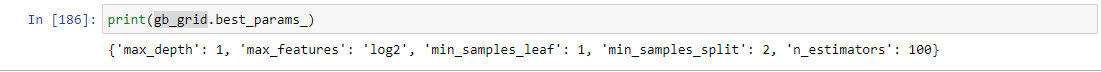

In [108]:
#df_gb_grid = pd.DataFrame(data=gb_grid.cv_results_)

In [109]:
#df_gb_grid.to_excel("Gradient_Boosted_GridSearch.xlsx")

### Best Fit Gradient Boosted Trees (precision)

In [110]:
gb = GradientBoostingClassifier(warm_start=False,
                                random_state=9,
                                max_depth=1,
                                max_features='log2',
                                min_samples_leaf=1,
                                min_samples_split=2,
                                n_estimators=100)
                                
gbm = gb.fit(df_train, y_train.ravel())
gbr = gbm.predict(df_train)
gbt = gbm.predict(df_test)

In [111]:
class_metrics(gbt)

Accuracy: 0.8785299806576402
Precision: 1.0
Recall: 0.006329113924050633


(None, None, None)

In [112]:
print(gb.get_params())

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 1, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 9, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


### Best Fit Gradient Boosted Trees (f1)

In [113]:
gb2 = GradientBoostingClassifier(warm_start=False,
                                random_state=9,
                                max_depth=None,
                                max_features='sqrt',
                                min_samples_leaf=4,
                                min_samples_split=10,
                                n_estimators=100)
                                
gbm2 = gb2.fit(df_train, y_train.ravel())
gbr2 = gbm2.predict(df_train)
gbt2 = gbm2.predict(df_test)

In [114]:
class_metrics(gbt2)

Accuracy: 0.9806576402321083
Precision: 0.975
Recall: 0.8639240506329114


(None, None, None)

In [115]:
print(gb2.get_params())

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 9, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


### Model - Hyertuned ExtraTrees

In [116]:
# n_estimators_e = [int(x) for x in np.linspace(start = 100, stop = 500, num = 3)]
# max_features_e = ['log2', 'sqrt']
# min_samples_split_e = [2, 5, 10]
# min_samples_leaf_e = [1, 2, 4]
# bootstrap_e = ['bool',False]
# criterion_e = ['gini','log_loss','entropy']
# random_grid_e = {
#                'n_estimators': n_estimators_e,
#                'max_features': max_features_e,
#                'min_samples_split': min_samples_split_e,
#                'min_samples_leaf': min_samples_leaf_e,
#                 'bootstrap': bootstrap_e,
#                 'criterion': criterion_e
#                 }
# print(random_grid_e)

In [117]:
# et = ExtraTreesClassifier(warm_start=False,random_state=9,class_weight='Balanced')
# et_grid = GridSearchCV(et,random_grid_e, cv = 5, verbose=2, scoring='precision')
# et_grid.fit(df_train, y_train.ravel())
# print(et_grid.best_estimator_)

In [118]:
# print(et_grid.best_params_)

In [119]:
# df_et_grid = pd.DataFrame(data=et_grid.cv_results_)

In [120]:
# df_et_grid.to_excel("ET_GridSearch.xlsx")

### Best Fit Extra Trees (precision)

In [121]:
et = ExtraTreesClassifier(
        warm_start=False,
        random_state=9,
        bootstrap=True,
        class_weight='balanced',
        criterion='log_loss',
        max_features='log2',
        min_samples_split=10)
etm = et.fit(df_train, y_train.ravel())
etr = etm.predict(df_train)
ett = etm.predict(df_test)

In [122]:
class_metrics(ett)

Accuracy: 0.9787234042553191
Precision: 0.9961977186311787
Recall: 0.8291139240506329


(None, None, None)

In [123]:
print(et.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 9, 'verbose': 0, 'warm_start': False}


### Best Fit Extra Trees (F1)

In [124]:
et2 = ExtraTreesClassifier(
        warm_start=False,
        random_state=9,
        bootstrap=False,
        class_weight='balanced',
        criterion='log_loss',
        max_features='log2',
        min_samples_split=10)
etm2 = et2.fit(df_train, y_train.ravel())
etr2 = etm2.predict(df_train)
ett2 = etm2.predict(df_test)

In [125]:
class_metrics(ett2)

Accuracy: 0.9794970986460348
Precision: 0.9747292418772563
Recall: 0.8544303797468354


(None, None, None)

In [126]:
print(et2.get_params())

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 9, 'verbose': 0, 'warm_start': False}


### Hypertuned ADA Boosting

In [127]:
# param_grid_ad = {'n_estimators': [int(x) for x in np.linspace(start = 20, stop = 300, num = 10)], 
#                  'learning_rate': [.1,.5,1]}
# grid_ad = GridSearchCV(AdaBoostClassifier(random_state=9),param_grid_ad,refit=True,verbose=3,scoring='precision',cv=5)
# adm = grid_ad.fit(df_train,y_train.ravel())

In [128]:
# print(grid_ad.best_estimator_)

In [129]:
# df_ad_grid = pd.DataFrame(data=grid_ad.cv_results_)

In [130]:
# df_ad_grid.to_excel("AD_GridSearch.xlsx")

### Best Fit ADA Boosting (precision)

In [131]:
ad = AdaBoostClassifier(random_state=9,learning_rate=0.1,n_estimators=20)
adm = ad.fit(df_train, y_train.ravel())
adr = adm.predict(df_train)
adt = adm.predict(df_test)

In [132]:
class_metrics(adt)

Accuracy: 0.9056092843326886
Precision: 1.0
Recall: 0.22784810126582278


(None, None, None)

In [133]:
print(ad.get_params())

{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 0.1, 'n_estimators': 20, 'random_state': 9}


### Best Fit ADA Bososting (f1)

In [134]:
ad2 = AdaBoostClassifier(random_state=9,learning_rate=0.5,n_estimators=268)
adm2 = ad2.fit(df_train, y_train.ravel())
adr2 = adm2.predict(df_train)
adt2 = adm2.predict(df_test)

In [135]:
class_metrics(adt2)

Accuracy: 0.9756286266924564
Precision: 0.9501779359430605
Recall: 0.8449367088607594


(None, None, None)

In [136]:
print(ad2.get_params())

{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 0.5, 'n_estimators': 268, 'random_state': 9}


### XGB Hypertuning

In [137]:
# params = {'max_depth': [3, 6, 10],
#               'learning_rate': [ 0.1, 0.5],
#               'subsample': np.arange(0.5, 1.0, 0.2),
#               'colsample_bytree': np.arange(0.5, 1.0, 0.2),
#               'colsample_bylevel': np.arange(0.5, 1.0, 0.2),
#               'n_estimators': [50, 100],
#               'num_class': [1]
#               }

In [138]:
# grid_xg = GridSearchCV(XGBClassifier(random_state=9,scale_pos_weight=20),params,refit=True,verbose=3,scoring='precision',cv=5,n_jobs=-2)
# xgm = grid_xg.fit(df_train,y_train.ravel())

In [139]:
# print(grid_xg.best_estimator_)

In [140]:
# df_xg_grid = pd.DataFrame(data=grid_xg.cv_results_)

In [141]:
# df_xg_grid.to_excel("XG_GridSearch.xlsx")

### Model - XGB Classifier (precision)

In [142]:
xg = XGBClassifier(
                    random_state=9,
                    colsample_bylevel=0.5, 
                    colsample_bytree=0.7, 
                    learning_rate=0.5, 
                    max_depth=6, 
                    n_estimators=100, 
                    num_class=1, 
                    subsample=0.9,
                    scale_pos_weight=20)
xgm = xg.fit(df_train, y_train.ravel())
xgr = xgm.predict(df_train)
xgt = xgm.predict(df_test)

In [143]:
class_metrics(xgt)

Accuracy: 0.9713733075435204
Precision: 0.8805031446540881
Recall: 0.8860759493670886


(None, None, None)

In [144]:
print(xg.get_params())

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': 0.5, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.5, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 9, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 20, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 1}


### Best Fit XGB Classifier (f1)

In [145]:
xg2 = XGBClassifier(
                    random_state=9,
                    colsample_bylevel=0.5, 
                    colsample_bytree=0.5, 
                    learning_rate=0.1, 
                    max_depth=10, 
                    n_estimators=250, 
                    num_class=1, 
                    subsample=0.75,
                    scale_pos_weight=20)
xgm2 = xg2.fit(df_train, y_train.ravel())
xgr2 = xgm2.predict(df_train)
xgt2 = xgm2.predict(df_test)

In [146]:
class_metrics(xgt2)

Accuracy: 0.9690522243713733
Precision: 0.8782051282051282
Recall: 0.8670886075949367


(None, None, None)

In [147]:
print(xg2.get_params())

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': 0.5, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 10, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 250, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 9, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 20, 'subsample': 0.75, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 1}


### Model XGBRF Classifier Hypertuning

In [148]:
# params_brf = {'max_depth': [3, 6, 10, 15],
#               'learning_rate': [ 0.1, 0.5, 1],
#               'subsample': np.arange(0.5, 1.0, 0.1),
#               'colsample_bytree': np.arange(0.5, 1.0, 0.1),
#               'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
#               'n_estimators': [50, 100, 250],
#               'num_class': [1]
#               }

### Model - XGBRF Classifier

In [149]:
xr = XGBRFClassifier(random_state=9)
xrm = xr.fit(df_train, y_train)
xrr = xrm.predict(df_train)
xrt = xrm.predict(df_test)

In [150]:
class_metrics(xrt)

Accuracy: 0.948936170212766
Precision: 0.9509803921568627
Recall: 0.6139240506329114


(None, None, None)

In [151]:
print(xr.get_params())

{'colsample_bynode': 0.8, 'learning_rate': 1.0, 'reg_lambda': 1e-05, 'subsample': 0.8, 'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 9, 'reg_alpha': None, 'sampling_method': None, 'scale_pos_weight': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


### Model_CNN

In [152]:
md_cnn = tf.keras.Sequential()
md_cnn.add(tf.keras.layers.Embedding(input_dim=len(d)+1, output_dim=64, input_length=x_train.shape[1]))
md_cnn.add(tf.keras.layers.GlobalAveragePooling1D())
md_cnn.add(tf.keras.layers.Dense(64, activation='relu'))
md_cnn.add(tf.keras.layers.Dense(32, activation='relu'))
md_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum = 0.95, nesterov=True)
md_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

md_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 79, 64)            436480    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 442,753
Trainable params: 442,753
Non-trainable params: 0
__________________________________________________

In [153]:
md_cnn.fit(x_train_array, y_train, epochs=50, callbacks=[callback])

Epoch 1/50
81/81 [==============================] - 1s 3ms/step - loss: 0.4626 - accuracy: 0.8696 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/50
81/81 [==============================] - 0s 3ms/step - loss: 0.3521 - accuracy: 0.8696 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/50
81/81 [==============================] - 0s 3ms/step - loss: 0.2994 - accuracy: 0.8707 - precision: 1.0000 - recall: 0.0089   
Epoch 4/50
81/81 [==============================] - 0s 3ms/step - loss: 0.1208 - accuracy: 0.9590 - precision: 0.9957 - recall: 0.6884
Epoch 5/50
81/81 [==============================] - 0s 3ms/step - loss: 0.0427 - accuracy: 0.9888 - precision: 0.9904 - recall: 0.9228
Epoch 6/50
81/81 [==============================] - 0s 3ms/step - loss: 0.0281 - accuracy: 0.9938 - precision: 0.9908 - recall: 0.9614
Epoch 7/50
81/81 [==============================] - 0s 3ms/step - loss: 0.0237 - accuracy: 0.9930 - precision: 0.9938 - recall: 0.9525
Epoch 8/50
81/81 [==================

In [154]:
cnt = md_cnn.predict(x_test_array, batch_size=None)
cnr = md_cnn.predict(x_train_array, batch_size=None)
cnt = np.concatenate(cnt).round().astype(int)
cnr = np.concatenate(cnr).round().astype(int)

81/81 [==============================] - 0s 1ms/step


In [155]:
class_metrics(cnt)

Accuracy: 0.9744680851063829
Precision: 0.9139072847682119
Recall: 0.8734177215189873


(None, None, None)

### Model - BiDirectional LSTM with Hidden Layers

In [156]:
#embedding layer and bidirectional layer
md_bidir_w_hidden = tf.keras.Sequential()
md_bidir_w_hidden.add(tf.keras.layers.Embedding(input_dim= len(d) + 1,output_dim=100,input_length=x_train.shape[1]))
md_bidir_w_hidden.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
md_bidir_w_hidden.add(tf.keras.layers.Dense(64, activation='relu'))
md_bidir_w_hidden.add(tf.keras.layers.Dense(32, activation='relu'))
md_bidir_w_hidden.add(tf.keras.layers.Dense(1, activation='sigmoid'))
md_bidir_w_hidden.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 79, 100)           682000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 776,849
Trainable params: 776,849
Non-trainable params: 0
________________________________________________

In [157]:
#compile the model
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum = 0.95, nesterov=True)
md_bidir_w_hidden.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy', 'Precision', 'Recall'])

In [158]:
#fit the model
md_bidir_w_hidden.fit(x_train_array, y_train, epochs=50, callbacks=[callback])

Epoch 1/50
81/81 [==============================] - 7s 51ms/step - loss: 0.4085 - accuracy: 0.8603 - precision: 0.1250 - recall: 0.0119
Epoch 2/50
81/81 [==============================] - 4s 51ms/step - loss: 0.3461 - accuracy: 0.8696 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/50
81/81 [==============================] - 4s 51ms/step - loss: 0.3110 - accuracy: 0.8696 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/50
81/81 [==============================] - 4s 52ms/step - loss: 0.2762 - accuracy: 0.8727 - precision: 0.9000 - recall: 0.0267
Epoch 5/50
81/81 [==============================] - 4s 52ms/step - loss: 0.1721 - accuracy: 0.9447 - precision: 0.9042 - recall: 0.6439
Epoch 6/50
81/81 [==============================] - 4s 52ms/step - loss: 0.0999 - accuracy: 0.9690 - precision: 0.9159 - recall: 0.8398
Epoch 7/50
81/81 [==============================] - 4s 52ms/step - loss: 0.0659 - accuracy: 0.9822 - precision: 0.9619 - recall: 0.8991
Epoch 8/50
81/81 [==============

In [159]:
ltt = md_bidir_w_hidden.predict(x_test_array, batch_size=None)
ltr = md_bidir_w_hidden.predict(x_train_array, batch_size=None)
ltt = np.concatenate(ltt).round().astype(int)
ltr = np.concatenate(ltr).round().astype(int)

81/81 [==============================] - 1s 17ms/step


In [160]:
class_metrics(ltt)

Accuracy: 0.9756286266924564
Precision: 0.953405017921147
Recall: 0.8417721518987342


(None, None, None)

### Model - BiDirectional LSTM with Convuluational Layer

In [161]:
#embedding layer and bidirectional layer
#md_combo = tf.keras.Sequential()
#md_combo.add(tf.keras.layers.Embedding(input_dim= len(d) + 1,output_dim=64,input_length=x_train.shape[1]))
#md_combo.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
#md_combo.add(tf.keras.layers.GlobalAveragePooling2D(64,input_shape=(3,32,32)))
#md_combo.add(Flatten())
#md_combo.add(tf.keras.layers.Dense(64, activation='relu'))
#md_combo.add(tf.keras.layers.Dense(32, activation='relu'))
#md_combo.add(tf.keras.layers.Dense(1, activation='sigmoid'))
#md_combo.summary()

In [162]:
#compile the model
#optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum = 0.95, nesterov=True)
#md_combo.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy', 'Precision', 'Recall'])

In [163]:
#fit the model
#md_combo.fit(x_train_array, y_train, epochs=50, callbacks=[callback])

### Report (Precision Hyptertuned)

In [202]:
methods = [lrt, gnt, bnt, mbt, sbt, rft, gbt, ett, adt, xgt, cnt, ltt]
method_name = ['LG','GNB','BNB','MNB','SVM','RF','GBT','ET','ADA','XGB','CNN','LTSM']
accuracy = []
precision = []
recall = []
f1 = []
for i in methods:
    accuracy.append(class_accuracy(i))
    precision.append(class_precision(i))
    recall.append(class_recall(i))
    f1.append(class_f1(i))
results = pd.DataFrame(
    {'Method': method_name,
     'Accuracy': accuracy,
     'Precision': precision,
     'Recall':recall,
     'F1':f1
    })


In [203]:
results

,Method,Accuracy,Precision,Recall,F1
0,LG,0.972534,0.918089,0.851266,0.883415
1,GNB,0.809671,0.382038,0.901899,0.536723
2,BNB,0.961702,0.990950,0.693038,0.815642
3,MNB,0.950484,0.737374,0.924051,0.820225
4,SVM,0.932689,0.943750,0.477848,0.634454
5,RF,0.964797,0.995595,0.715190,0.832413
6,GBT,0.878530,1.000000,0.006329,0.012579
7,ET,0.978723,0.996198,0.829114,0.905009
8,ADA,0.905609,1.000000,0.227848,0.371134
9,XGB,0.971373,0.880503,0.886076,0.883281


### Report (f1 Hyptertuned)

In [204]:
methods2 = [lrt, gnt, bnt, mbt, sbt2, rft2, gbt2, ett2, adt2, xgt2, cnt, ltt]
method_name2 = ['LG','GNB','BNB','MNB','SVM','RF','GBT','ET','ADA','XGB','CNN','LTSM']
accuracy2 = []
precision2 = []
recall2 = []
f12 = []
for i in methods2:
    accuracy2.append(class_accuracy(i))
    precision2.append(class_precision(i))
    recall2.append(class_recall(i))
    f12.append(class_f1(i))
results2 = pd.DataFrame(
    {'Method': method_name2,
     'Accuracy': accuracy2,
     'Precision': precision2,
     'Recall':recall2,
     'F1':f12
    })

In [205]:
results2

,Method,Accuracy,Precision,Recall,F1
0,LG,0.972534,0.918089,0.851266,0.883415
1,GNB,0.809671,0.382038,0.901899,0.536723
2,BNB,0.961702,0.990950,0.693038,0.815642
3,MNB,0.950484,0.737374,0.924051,0.820225
4,SVM,0.966344,0.987234,0.734177,0.842105
5,RF,0.982205,0.972028,0.879747,0.923588
6,GBT,0.980658,0.975000,0.863924,0.916107
7,ET,0.979497,0.974729,0.854430,0.910624
8,ADA,0.975629,0.950178,0.844937,0.894472
9,XGB,0.969052,0.878205,0.867089,0.872611


### Creating a Train Data Predictions DataFrame

This dataframe will be used to first identify false positives and then calculate the jaccard score amongst false negatives

In [206]:
yy = s_pandas['label'].iloc[train_index]
train_predictions = [lrr, gnr, bnr, mbr, sbr2, rfr2, gbr2, etr2, adr2, xgr2, cnr, ltr]
for i in train_predictions:
    i = i.tolist()
train_results = list(zip(yy,lrr, gnr, bnr, mbr, sbr2, rfr2, gbr2, etr2, adr2, xgr2, cnr, ltr))
df_results = pd.DataFrame(data=train_results,columns=['actual','LG','GNB','BNB','MNB','SVM','RF','GBT','ET','ADA','XGB','CNN','LTSM'])

In [207]:
tn_list = []
fp_list = []
fn_list = []
tp_list = []
for i in range(len(train_predictions)):
    tn, fp, fn, tp = confusion_matrix(yy, train_predictions[i], labels=[0, 1]).ravel()
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)
    tp_list.append(tp)
confusion = list(zip(method_name,tn_list,fp_list,fn_list,tp_list))
df_confusion = pd.DataFrame(data=confusion,columns=['Method','True Positive','False Positive','False Negative','True Positive'])
df_confusion

,Method,True Positive,False Positive,False Negative,True Positive
0,LG,2243,4,3,334
1,GNB,1883,364,0,337
2,BNB,2247,0,74,263
3,MNB,2174,73,6,331
4,SVM,2247,0,1,336
5,RF,2247,0,1,336
6,GBT,2247,0,3,334
7,ET,2247,0,1,336
8,ADA,2247,0,2,335
9,XGB,2238,9,1,336


### Creating a Test Data Predictions DataFrame

In [208]:
yz = s_pandas['label'].iloc[test_index]
test_predictions = [lrt, gnt, bnt, mbt, sbt2, rft2, gbt2, ett2, adt2, xgt2, cnt, ltt]
for i in test_predictions:
    i = i.tolist()
test_results = list(zip(yz,lrt, gnt, bnt, mbt, sbt2, rft2, gbt2, ett2, adt2, xgt2, cnt, ltt))
df_results_test = pd.DataFrame(data=test_results,columns=['actual','LG','GNB','BNB','MNB','SVM','RF','GBT','ET','ADA','XGB','CNN','LTSM'])

In [209]:
tn2_list = []
fp2_list = []
fn2_list = []
tp2_list = []
for i in range(len(test_predictions)):
    tn, fp, fn, tp = confusion_matrix(yz, test_predictions[i], labels=[0, 1]).ravel()
    tn2_list.append(tn)
    fp2_list.append(fp)
    fn2_list.append(fn)
    tp2_list.append(tp)
confusion2 = list(zip(method_name,tn2_list,fp2_list,fn2_list,tp2_list))
df_confusion2 = pd.DataFrame(data=confusion2,columns=['Method','True Positive','False Positive','False Negative','True Positive'])
df_confusion2

,Method,True Positive,False Positive,False Negative,True Positive
0,LG,2245,24,47,269
1,GNB,1808,461,31,285
2,BNB,2267,2,97,219
3,MNB,2165,104,24,292
4,SVM,2266,3,84,232
5,RF,2261,8,38,278
6,GBT,2262,7,43,273
7,ET,2262,7,46,270
8,ADA,2255,14,49,267
9,XGB,2231,38,42,274


### Creating a DataFrame of False Positives

In [226]:
docs = s_pandas['doc'].iloc[test_index]

In [210]:
fp_list = []
for i in method_name:
    fp_list.append(np.where(
            ((df_results['actual'] == 1) & (df_results[i] == 0))
        |   ((df_results['actual'] == 0) & (df_results[i] == 1))
            ,1,0).tolist())

In [227]:
df_fp = pd.DataFrame(data=fp_list)
df_fp = df_fp.transpose()
df_fp = df_fp.set_axis(method_name,axis=1)
df_fp_test = df_fp
df_fp_test['docs'] = docs

In [228]:
len(method_name)

12

In [229]:
df_fp.MNB.sum()

79

In [231]:
df_fp_test.head()

,LG,GNB,BNB,MNB,SVM,RF,GBT,ET,ADA,XGB,CNN,LTSM,docs
0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
1,0,1,0,1,0,0,0,0,0,0,0,0,ok lar joke wif oni
2,0,0,0,0,0,0,0,0,0,0,0,0,free entri wkli comp win fa cup final tkt may ...
3,0,0,0,0,0,0,0,0,0,0,0,0,NaN
4,0,0,0,0,0,0,0,0,0,0,0,0,nah think goe usf live around though


In [233]:
df_fp_test[df_fp_test['ADA'] == 1]

,LG,GNB,BNB,MNB,SVM,RF,GBT,ET,ADA,XGB,CNN,LTSM,docs
815,0,0,1,1,0,0,0,0,1,0,0,0,thank much skype wit kz sura didnt get pleasur...
1959,1,0,1,1,1,1,1,1,1,1,1,1,avatar suppos subtoitl


### Jaccard Score Matrix

In [215]:
#calculate the jaccard scores
method1 = []
method2 = []
jac = []
for x in method_name:
    for y in method_name:
        method1.append(x)
        method2.append(y)
        jac.append(jaccard_score(df_fp[x],df_fp[y]))

In [216]:
#put into a matrix
d = list(zip(method1,method2,jac))
df_j = pd.DataFrame(data=d,columns=('method1','method2','jac'))
table = pd.pivot_table(df_j,values='jac',index='method1',columns='method2',aggfunc=np.sum)
table

method2,ADA,BNB,CNN,ET,GBT,GNB,LG,LTSM,MNB,RF,SVM,XGB
method1,,,,,,,,,,,,
ADA,1.000000,0.027027,0.200000,0.500000,0.250000,0.000000,0.125000,0.500000,0.025316,0.500000,0.500000,0.090909
BNB,0.027027,1.000000,0.026316,0.013514,0.040541,0.000000,0.038462,0.013514,0.040816,0.013514,0.013514,0.012048
CNN,0.200000,0.026316,1.000000,0.250000,0.400000,0.005464,0.375000,0.250000,0.037500,0.250000,0.250000,0.166667
ET,0.500000,0.013514,0.250000,1.000000,0.333333,0.000000,0.142857,1.000000,0.012658,1.000000,1.000000,0.100000
GBT,0.250000,0.040541,0.400000,0.333333,1.000000,0.000000,0.250000,0.333333,0.012346,0.333333,0.333333,0.083333
GNB,0.000000,0.000000,0.005464,0.000000,0.000000,1.000000,0.005420,0.000000,0.101990,0.000000,0.000000,0.010811
LG,0.125000,0.038462,0.375000,0.142857,0.250000,0.005420,1.000000,0.142857,0.061728,0.142857,0.142857,0.214286
LTSM,0.500000,0.013514,0.250000,1.000000,0.333333,0.000000,0.142857,1.000000,0.012658,1.000000,1.000000,0.100000
MNB,0.025316,0.040816,0.037500,0.012658,0.012346,0.101990,0.061728,0.012658,1.000000,0.012658,0.012658,0.112500


### 3 Approach Voting Results

In [178]:
def vote_prediction(method1,method2,method3):
    pred = []
    for i in range(len(method1)):
        pred.append(round((method1[i]+method2[i]+method3[i])/3))
    return pred;

### Ensemble Method

In [224]:
en1 = vote_prediction(rft2,ett,gbt2)
en2 = vote_prediction(gbt2,ett2,ett)
en3 = vote_prediction(ett,ett2,mbt)
en4 = vote_prediction(xgt2,gbt2,mbt)
en5 = vote_prediction(adt2,lrt,mbt)
en6 = vote_prediction(rft2,gbt2,mbt)

In [225]:
methods_final = [lrt, gnt, bnt, mbt, sbt2, rft2, gbt2, ett2, adt2, xgt2, cnt, ltt, en1,en2,en3,en4,en5,en6]
method_name_final = ['LG','GNB','BNB','MNB','SVM','RF','GBT','ET','ADA','XGB','CNN','LTSM','En1','En2','En3','En4','En5',"En6"]
accuracy3 = []
precision3 = []
recall3 = []
f13 = []
for i in methods_final:
    accuracy3.append(class_accuracy(i))
    precision3.append(class_precision(i))
    recall3.append(class_recall(i))
    f13.append(class_f1(i))
results3 = pd.DataFrame(
    {'Method': method_name_final,
     'Accuracy': accuracy3,
     'Precision': precision3,
     'Recall':recall3,
     'F1':f13
    })
results3

,Method,Accuracy,Precision,Recall,F1
0,LG,0.972534,0.918089,0.851266,0.883415
1,GNB,0.809671,0.382038,0.901899,0.536723
2,BNB,0.961702,0.990950,0.693038,0.815642
3,MNB,0.950484,0.737374,0.924051,0.820225
4,SVM,0.966344,0.987234,0.734177,0.842105
5,RF,0.982205,0.972028,0.879747,0.923588
6,GBT,0.980658,0.975000,0.863924,0.916107
7,ET,0.979497,0.974729,0.854430,0.910624
8,ADA,0.975629,0.950178,0.844937,0.894472
9,XGB,0.969052,0.878205,0.867089,0.872611


### Testing False Positive Metrics

In [181]:
# ET_train_predictions = etm.predict(df_train).tolist()
# ADA_train_predictions = adm.predict(df_train).tolist()
# actual = y_train.tolist()
# results = list(zip(actual,ET_train_predictions,ADA_train_predictions))

In [182]:
# df_results = pd.DataFrame(data=results,columns=['actual','ET','ADA'])

In [183]:
# df_results.to_excel("FP.xlsx")

In [184]:
# predict_metrics(ET_train_predictions)

In [185]:
# predict_metrics(ADA_train_predictions)

In [186]:
# from sklearn.metrics import confusion_matrix
# tn, fp, fn, tp = confusion_matrix(actual, ADA_train_predictions, labels=[0, 1]).ravel()
# print(tn, fp, fn, tp)  # 1 1 1 1

In [187]:
# tn, fp, fn, tp = confusion_matrix(actual, ET_train_predictions, labels=[0, 1]).ravel()
# print(tn, fp, fn, tp)  # 1 1 1 1

In [188]:
# actual[0]

In [189]:
# df_results['ADA_FP'] = np.where(df_results['ADA'] == 0 & df_results['actual'] == 1,1,0)

In [190]:
# sum(df_results.ADA_FP.tolist())

In [191]:
a = [0,0,0,0,1,0,0,1,0,0]
b = [0,1,0,0,0,0,0,1,0,0]

In [192]:
jaccard_score(a,b)

0.3333333333333333

In [193]:
c = [0,1,0,0,0,0,0,0,0,0]
d = [0,0,0,0,0,0,0,1,0,0]

In [194]:
jaccard_score(c,d)

0.0

### Pickle Predictions

In [195]:
#pickle predictions
with open('session.pkl', 'wb') as f:
    pickle.dump({
            'cnt' : cnt,
            'ltt' : ltt,
            'lrt' : lrt,
            'gnt' : gnt,
            'bnt' : bnt,
            'mbt' : mbt,
            'srt' : srt,
            'spt' : spt,
            'slt' : slt,
            'rft' : rft,
            'gbt' : gbt,
            'ett' : ett,
            'adt' : adt,
            'xgt' : xgt,
            'xrt' : xrt,
            'cnr' : cnr,
            'ltr' : ltr,
            'lrr' : lrr,
            'gnr' : gnr,
            'bnr' : bnr,
            'mbr' : mbr,
            'srr' : srr,
            'spr' : spr,
            'slr' : slr,
            'rfr' : rfr,
            'gbr' : gbr,
            'etr' : etr,
            'adr' : adr,
            'xgr' : xgr,
            'xrr' : xrr
                }, f)

NameError: name 'srt' is not defined

In [237]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [238]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

C:\Users\CGLam\anaconda3_\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\CGLam\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [239]:
def bert_encode(input_text, max_len):
    input_ids = []
    attension_masks = []
    for text in input_text:
        output_dict = tokenizer.encode_plus(
            text, 
            add_special_tokens = True,
            truncation=True,
            max_length = max_len,
            pad_to_max_length = True,
            return_attention_mask = True
        )
        input_ids.append(output_dict['input_ids'])
        attension_masks.append(output_dict['attention_mask'])
    return np.array(input_ids), np.array(attension_masks)

In [247]:
text = s_pandas['doc']
target = s_pandas['label']
train_input_ids, train_attention_masks = bert_encode(text, 60)

C:\Users\CGLam\anaconda3_\lib\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [256]:
def create_model(bert_model):
    input_ids = tf.keras.Input(shape= (60,), dtype= 'int32')
    attention_masks = tf.keras.Input(shape= (60,), dtype= 'int32')
    
    output = bert_model([input_ids, attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32, activation= 'relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1, activation= 'sigmoid')(output)
    
    model = tf.keras.models.Model(inputs= [input_ids, attention_masks], outputs= output)
    model.compile(Adam(lr=1e-5), loss= 'binary_crossentropy', metrics= ['f1'])
    return model

In [257]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [258]:
model = create_model(bert_model)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_7[0][0]',                
                                thPoolingAndCrossAt               'input_8[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                          

In [259]:
%%time

history = model.fit(
    [train_input_ids, train_attention_masks],
    target, 
    validation_split = 0.5,
    epochs = 3,
    batch_size = 10
)

Epoch 1/3


ValueError: in user code:

    File "C:\Users\CGLam\anaconda3_\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\CGLam\anaconda3_\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\CGLam\anaconda3_\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\CGLam\anaconda3_\lib\site-packages\keras\engine\training.py", line 998, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\CGLam\anaconda3_\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\CGLam\anaconda3_\lib\site-packages\keras\engine\compile_utils.py", line 577, in update_state
        self.build(y_pred, y_true)
    File "C:\Users\CGLam\anaconda3_\lib\site-packages\keras\engine\compile_utils.py", line 483, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "C:\Users\CGLam\anaconda3_\lib\site-packages\keras\engine\compile_utils.py", line 631, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "C:\Users\CGLam\anaconda3_\lib\site-packages\keras\engine\compile_utils.py", line 631, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "C:\Users\CGLam\anaconda3_\lib\site-packages\keras\engine\compile_utils.py", line 650, in _get_metric_object
        metric_obj = metrics_mod.get(metric)
    File "C:\Users\CGLam\anaconda3_\lib\site-packages\keras\metrics\__init__.py", line 181, in get
        return deserialize(str(identifier))
    File "C:\Users\CGLam\anaconda3_\lib\site-packages\keras\metrics\__init__.py", line 136, in deserialize
        return deserialize_keras_object(
    File "C:\Users\CGLam\anaconda3_\lib\site-packages\keras\utils\generic_utils.py", line 769, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown metric function: f1. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
